# Training in mini-batches: Stochastic gradient descent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/7.SGD-minibatch-diabetes.ipynb)

We've been using generic gradient descent to optimize our model so far.  Because we've been estimating gradients using the entire `X` matrix, we call this batch gradient descent. Each update of the model parameters after considering all training instances is called an epoch. For batch gradient descent, there is one loss function computation per epoch.  If we process the training data in chunks rather than a single batch, we call it mini-batch gradient descent, or more commonly stochastic gradient descent (SGD). It is called stochastic because of the imprecision and, hence, randomness introduced by the computation of gradients on a subset of the training data. After we've computed a gradient and updated weights using all training instances, we call that an epoch, shuffle the batches, and do another epoch.

## Why minibatch vs batch gradient descent?

<a href="https://twitter.com/ylecun/status/989610208497360896"><img src="https://explained.ai/rnn/images/lecunn-batch-size.png" width="250" align="right"></a>
Sometimes we have so much data that it will not fit on our GPU all at once; decent GPUs typically have around 12G of RAM.  For big problems, we need to break it up into batches.
 
Also, and possibly a more important goal, is to get better generalization; i.e., smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower and better minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

To avoid combining too many concepts at once, let's run the diabetes example again and on the CPU not a GPU.  That way we can focus on just the stochastic gradient descent issue.

In [1]:
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [5]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [6]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

In [7]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 455.43 validation MSE 3405.60


In [8]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [9]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32,
             trace=True):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    29581.213   test loss    24394.588
Epoch   20 MSE train loss     2407.076   test loss     3619.026
Epoch   40 MSE train loss     2392.134   test loss     3742.122
Epoch   60 MSE train loss     2194.301   test loss     3981.246
Epoch   80 MSE train loss     3253.490   test loss     4039.090
Epoch  100 MSE train loss     1786.359   test loss     4226.531
Epoch  120 MSE train loss     2126.033   test loss     4735.313
Epoch  140 MSE train loss     1590.492   test loss     4114.840
Epoch  160 MSE train loss     1620.046   test loss     4582.453
Epoch  180 MSE train loss     1697.997   test loss     4422.171
Epoch  200 MSE train loss     1492.945   test loss     4349.369
BEST MSE test loss 3582.612 at epoch 17


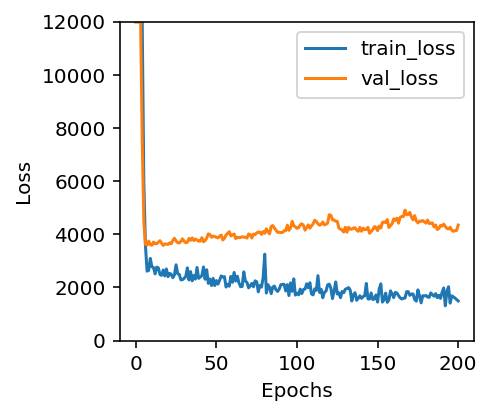

In [10]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.BatchNorm1d(n_neurons),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.005, nepochs=200, batch_size=16)

# verify we got the best model out
y_pred = best_model(X_test)
best_loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

Epoch    0 MSE train loss     5838.836   test loss     3524.562
Epoch   10 MSE train loss     3433.844   test loss     3670.264
Epoch   20 MSE train loss     3454.574   test loss     3424.815
Epoch   30 MSE train loss     3263.275   test loss     3553.016
Epoch   40 MSE train loss     3197.951   test loss     3401.839
Epoch   50 MSE train loss     3281.863   test loss     3456.923
Epoch   60 MSE train loss     3295.706   test loss     3488.443
Epoch   70 MSE train loss     3207.288   test loss     3562.213
Epoch   80 MSE train loss     3072.574   test loss     3790.088
Epoch   90 MSE train loss     3339.963   test loss     3476.753
Epoch  100 MSE train loss     3227.143   test loss     3454.204
BEST MSE test loss 3279.031 at epoch 16
Epoch    0 MSE train loss    27535.635   test loss    19113.258
Epoch   10 MSE train loss     2615.797   test loss     3694.148
Epoch   20 MSE train loss     2887.451   test loss     3739.795
Epoch   30 MSE train loss     2375.895   test loss     4001.407


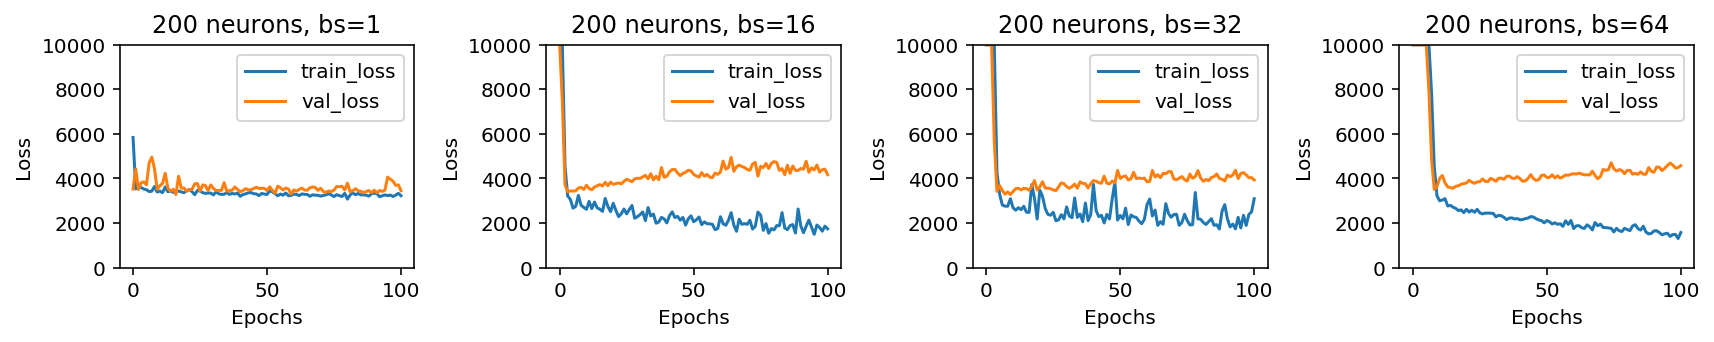

In [12]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

n_neurons = 200
for bs,ax in zip([1,16,32,64],axes):
    if bs>1:
        model = nn.Sequential(
            nn.Linear(ncols, n_neurons),
            nn.ReLU(),
            nn.BatchNorm1d(n_neurons),
            nn.Linear(n_neurons, 1)
        )
    else:
        model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(ncols, n_neurons),
            nn.Linear(n_neurons, 1)
        )
    history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                                   learning_rate=.015, nepochs=100, batch_size=bs,
                                   trace=True)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()